In [ ]:
%matplotlib notebook


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

### Task 2 Importing the data

In [7]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [12]:
x_train=np.reshape(x_train, (60000, 784))/255.
x_test=np.reshape(x_test, (10000,784))/255.
print(x_train.shape)

(60000, 784)


### Task 3 Plotting

In [13]:
def plot_triplet(triplet):
    plt.figure(figsize=(6, 2))
    for i in range(0, 3):
        plt.subplot(1, 3, i+1)
        plt.imshow(np.reshape(triplet[i],(28,28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()


<IPython.core.display.Javascript object>


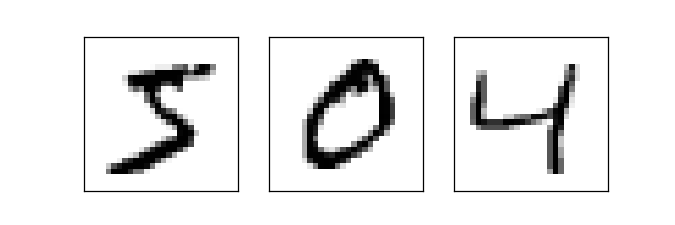

In [15]:
plot_triplet([x_train[0], x_train[1], x_train[2]])

## Task 4 Batch of triplets

In [41]:
def create_batch(batch_size):
    anchors=np.zeros((batch_size, 784))
    positives=np.zeros((batch_size, 784))
    negatives=np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        index=random.randint(0, 60000 - 1)
        anc=x_train[index]
        y=y_train[index]
        
        indices_for_pos=np.squeeze(np.where(y_train == y))
        indices_for_neg=np.squeeze(np.where(y_train != y))
        
        pos=x_train[indices_for_pos[random.randint(0, len(indices_for_pos) -1)]]
        neg=x_train[indices_for_neg[random.randint(0, len(indices_for_neg) -1)]]
        
        
        anchors[i]=anc
        positives[i]=pos
        negatives[i]=neg
        
    return [anchors, positives, negatives]

<IPython.core.display.Javascript object>


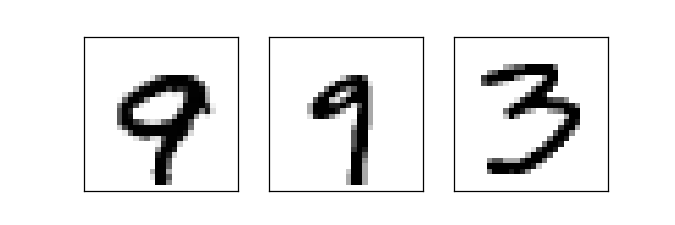

In [42]:
triplet=create_batch(1)
plot_triplet(triplet)

### TASK 5: Embedding model

In [44]:
emb_dim=64

embedding_model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
Total params: 54400 (212.50 KB)
Trainable params: 54400 (212.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
example=x_train[0]
example_emb=embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

1/1 [==============================] - 0s 16ms/step
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


### Task 6 Siamese Network

In [53]:
in_anc=tf.keras.layers.Input(shape=(784,))
in_pos=tf.keras.layers.Input(shape=(784,))
in_neg=tf.keras.layers.Input(shape=(784,))

em_anc=embedding_model(in_anc)
em_pos=embedding_model(in_pos)
em_neg=embedding_model(in_neg)

out= tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)


net=tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out

)
net.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 64)                   54400     ['input_14[0][0]',            
                                                                     'input_15[0][0]',      

### Task 7: Triplet Loss

In [ ]:
alpha=0.2
